## 1. 데이터 처리와 분류
---
- 라벨 데이터 처리하기
- sklearn의 rain_test_split함수를 이용하여 train, test 분리

### 데이터 불러오기

In [35]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os
#환경변수 os.getenv()를 사용하는 게 좋다. 값이 없을 경우엔 None을 리턴한다.
data_path = os.getenv("HOME") + '/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

### 데이터셋 살펴보기

In [36]:
print('Wave data shape: ', speech_data['wav_vals'].shape)
print('Label data shape: ', speech_data['label_vals'].shape)

Wave data shape:  (50620, 8000)
Label data shape:  (50620, 1)


In [37]:
import IPython.display as ipd #Create an audio object.
import random

rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  32855
Wave data shape :  (8000,)
label :  ['on']


In [38]:
#label_value에 key값을 추가해 주고, 딕셔너리로 변환

target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [39]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

#### sklearn의 train_test_split함수를 이용하여 train, test 분리 

In [40]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])
print("✅")

[[ 0.00159187  0.00214903 -0.00201404 ...  0.00022962 -0.00021427
  -0.0043959 ]
 [-0.00014021 -0.00165422 -0.00528675 ...  0.00358524  0.00415097
   0.00272197]
 [ 0.0028318   0.00382416 -0.00092823 ...  0.00350109  0.00297743
  -0.00190441]
 ...
 [ 0.00288335  0.00322558 -0.00145414 ...  0.00389349  0.0031057
  -0.00032394]
 [-0.00858209 -0.01957633 -0.02979492 ...  0.02329457  0.03783366
   0.03141765]
 [ 0.00347388  0.00597733  0.00660273 ... -0.00754197 -0.00514984
  -0.0054289 ]]
✅


In [41]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 8000, 1)
train labels :  (45558,)
test data :  (5062, 8000, 1)
test labels :  (5062,)
✅


### 2. 학습을 위한 하이퍼파라미터 설정

In [42]:
batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/ssac15/aiffel/speech_recognition/models/wav'

In [43]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


### 3. 데이터셋 구성

In [44]:
#tf.data.Dataset 함수를 구성

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


In [45]:
del speech_data #메모리 비워주기

### 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성


   * 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
   * batchnorm, dropout, dense layer 등을 이용
   * 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
   * 모델 가중치를 저장하는 checkpoint callback 함수 추가
   * 다양한 모델의 실험을 진행해 보시기 바랍니다.

In [46]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [47]:
# 위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


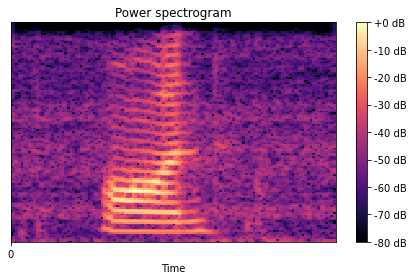

In [48]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

### Conv1d 모델

In [70]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 8000, 32)          320       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 4000, 32)          0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 2000, 64)          0   

In [71]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])


In [72]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                    verbose=1)

In [73]:
#30분 내외 소요
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 0.6868 - accuracy: 0.7928
Epoch 00001: val_loss improved from inf to 0.64403, saving model to /home/ssac15/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 173s 122ms/step - loss: 0.6868 - accuracy: 0.7928 - val_loss: 0.6440 - val_accuracy: 0.7858
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.3688 - accuracy: 0.9012
Epoch 00002: val_loss improved from 0.64403 to 0.44843, saving model to /home/ssac15/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 174s 122ms/step - loss: 0.3688 - accuracy: 0.9012 - val_loss: 0.4484 - val_accuracy: 0.8564
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.1986 - accuracy: 0.9528
Epoch 00003: val_loss did not improve from 0.44843
1423/1423 [==============================] - 173s 122ms/step - loss: 0.1986 - accuracy: 0.9528 - val_loss: 0.5347 - val_accuracy: 0

### 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

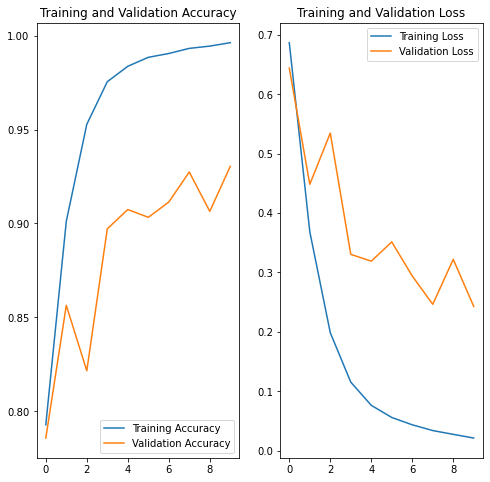

In [74]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [75]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

159/159 [==============================] - 5s 33ms/step - loss: 0.2425 - accuracy: 0.9305
loss value: 0.243
accuracy value: 93.0462%


### 6. Test dataset을 이용해서 모델의 성능을 평가

In [76]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  down


In [77]:
#테스트셋의 라벨과 우리 모델의 실제 prediction 결과를 비교

if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

y_pred: down(Correct!)


### 7. Skip-connection 모델에 적용하기

In [66]:
input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 8000, 32)     320         input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 8000, 32)     9248        conv1d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_8 (MaxPooling1D)  (None, 4000, 32)     0           conv1d_21[0][0]                  
____________________________________________________________________________________________

In [78]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [79]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [80]:
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9965
Epoch 00001: val_loss improved from inf to 0.23753, saving model to /home/ssac15/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 172s 121ms/step - loss: 0.0185 - accuracy: 0.9965 - val_loss: 0.2375 - val_accuracy: 0.9367
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9970
Epoch 00002: val_loss did not improve from 0.23753
1423/1423 [==============================] - 171s 120ms/step - loss: 0.0162 - accuracy: 0.9970 - val_loss: 0.2772 - val_accuracy: 0.9294
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9975
Epoch 00003: val_loss did not improve from 0.23753
1423/1423 [==============================] - 172s 121ms/step - loss: 0.0137 - accuracy: 0.9975 - val_loss: 0.3113 - val_accuracy: 0.9173
Epoch 4/10
1423/1423 [==============================] - ETA: 0s - loss

### Skip모델 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

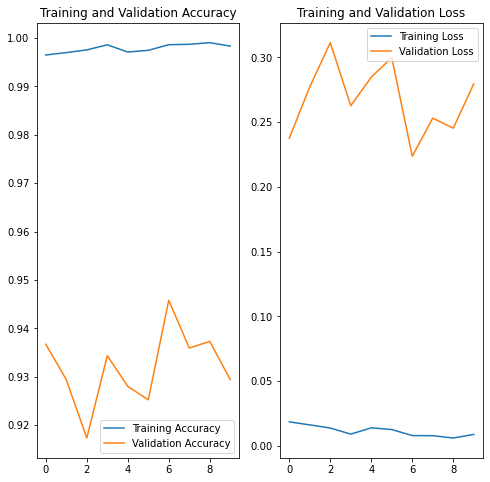

In [82]:
acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [83]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

159/159 [==============================] - 5s 34ms/step - loss: 0.2240 - accuracy: 0.9457
loss value: 0.224
accuracy value: 94.5674%


## 오예~~~ 94% !!!

In [84]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  go


In [86]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

y_pred: go(Correct!)


### 총평
* Conv1D 과 Skip-connection model의 결과 Skip-connection에서 성능이 약간 향상되었다. 
* Data 크기에서 메모리가 감당이 안되는것 같아 데이터를 30000개로 잘라보기도 하였으나, 노드를 다시 살펴보면서  del명령어로 메모리 공간을 비울 수 있다는걸 알았다. 
* 모르는게 너무 많아서 일일이 명령어와 함수 검색하는데 시간이 많이 걸리지만, 이번 과제처럼 성능이 잘나오면 정말 신기한것 같다. 딥러닝 생각해 낸 사람은 정말 천재이심~!!
* 아직도 갈 길이 멀지만 벌써 이미지, 텍스트, 음성까지 다뤄봤다는게.. 신기방기 하다. 